In [17]:
from typing import Callable

import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
import math


LENGTH = 1.


#def initial_condition(x) -> torch.Tensor:
#    res = torch.sign(x-0.5).reshape(-1, 1)
#    return res


class PINN(nn.Module):
    """Simple neural network accepting two features as input and returning a single output
    
    In the context of PINNs, the neural network is used as universal function approximator
    to approximate the solution of the differential equation
    """
    def __init__(self, num_hidden: int, dim_hidden: int, act=nn.Tanh(), pinning: bool = False):

        super().__init__()

        self.pinning = pinning

        self.layer_in = nn.Linear(1, dim_hidden)
        self.layer_out = nn.Linear(dim_hidden, 1)

        num_middle = num_hidden - 1
        self.middle_layers = nn.ModuleList(
            [nn.Linear(dim_hidden, dim_hidden) for _ in range(num_middle)]
        )
        self.act = act

    def forward(self, x):

        x_stack = torch.cat([x], dim=1)        
        out = self.act(self.layer_in(x_stack))
        for layer in self.middle_layers:
            out = self.act(layer(out))
        logits = self.layer_out(out)

        # if requested pin the boundary conditions 
        # using a surrogate model: (x - 0) * (x - L) * NN(x)
        if self.pinning:
            logits *= (x - x[0]) * (x - x[-1])
        
        return logits

def f(nn_approximator: PINN, x: torch.Tensor) -> torch.Tensor:
    """Compute the value of the approximate solution from the NN model"""
    print("PINN value: ", nn_approximator(x))
    return nn_approximator(x)


def df(output: torch.Tensor, input: torch.Tensor, order: int = 1) -> torch.Tensor:
    """Compute neural network derivative with respect to input features using PyTorch autograd engine"""
    df_value = output
    for _ in range(order):
        df_value = torch.autograd.grad(
            df_value,
            input,
            grad_outputs=torch.ones_like(input),
            create_graph=True,
            retain_graph=True,
        )[0]

    return df_value


def dfdt(nn_approximator: PINN, x: torch.Tensor, t: torch.Tensor, order: int = 1):
    """Derivative with respect to the time variable of arbitrary order"""
    f_value = f(nn_approximator, x, t)
    return df(f_value, t, order=order)


def dfdx(nn_approximator: PINN, x: torch.Tensor, order: int = 1):
    """Derivative with respect to the spatial variable of arbitrary order"""
    f_value = f(nn_approximator, x)
    return df(f_value, x, order=order)


def compute_loss(
    nn_approximator: PINN, x: torch.Tensor = None, device = "cpu"
) -> torch.float:
    """Compute the full loss function as interior loss + boundary loss
    This custom loss function is fully defined with differentiable tensors therefore
    the .backward() method can be applied to it
    """

    eps = 0.1

    # PDE residual
    # interior_loss = dfdt(nn_approximator, x, t, order=2) - G * (dfdx(nn_approximator, x, t, order=2) * f(nn_approximator, x, t) + dfdx(nn_approximator, x, t, order=1).pow(2))
    interior_loss = -eps * dfdx(nn_approximator, x, order=2) + dfdx(nn_approximator, x, order=1)

    #this goes to 0 at 0, so we need to modify left b.c. to be 0 at 0
    exact_loss = f(nn_approximator, x)-((pow( 2.718281828459045,1.0/eps)-1.0) * x +1.0 - pow( 2.718281828459045,x/eps))  / (pow( 2.718281828459045,1.0/eps)-1.0)
    exact_loss = f(nn_approximator,x)-1.0

    boundary_xi = x[-1].reshape(-1, 1) #last point = 1
    boundary_loss_xi = f(nn_approximator, boundary_xi)
    
    boundary_xf = x[0].reshape(-1, 1) #first point = 0
    boundary_loss_xf = -eps * dfdx(nn_approximator, boundary_xf) + f(nn_approximator, boundary_xf)-1.0
    #boundary_loss_xf = f(nn_approximator, boundary_xi)-1.0

#    extra_loss = pow(eps,0.5)*dfdx(nn_approximator, x, order=1)

    # obtain the final MSE loss by averaging each loss term and summing them up
    final_loss = \
        interior_loss.pow(2).mean() + \
        boundary_loss_xf.pow(2).mean() + \
        boundary_loss_xi.pow(2).mean() #+ \
        #exact_loss.pow(2).mean() 

    return final_loss


def train_model(
    nn_approximator: PINN,
    loss_fn: Callable,
    learning_rate: int = 0.01,
    max_epochs: int = 1_000,
    device="cpu"
) -> PINN:

    optimizer = torch.optim.Adam(nn_approximator.parameters(), lr=learning_rate)
    for epoch in range(max_epochs):

        try:

            loss: torch.Tensor = loss_fn(nn_approximator)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if epoch % 100 == 0:
                print(f"Epoch: {epoch} - Loss: {float(loss):>7f}")

        except KeyboardInterrupt:
            break

    return nn_approximator





In [18]:
from functools import partial
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#x_domain = [0.0, 0.98 * LENGTH, LENGTH]; n_points_x = 100
eps=0.1
x_domain = [0.0, (1.0-5.0*eps) * LENGTH, LENGTH]; n_points_x = 100
# there is a total of 100 points from 0 to 0.98 and 100 points from 0.98 to 1.0
x_raw_1 = torch.linspace(x_domain[0], x_domain[1], steps=n_points_x)
x_raw_2 = torch.linspace(x_domain[1], x_domain[2], steps=n_points_x)
x_raw = torch.cat((x_raw_1, x_raw_2), dim=0)
#x_raw = torch.normal(mean=0.5, std=0.2, size=(n_points_x,)).sort()[0]
x_raw.requires_grad_()

x = x_raw.reshape(-1, 1).to(device)

exact_sol = ((pow( 2.718281828459045,1.0/eps)-1.0) * x +1.0 - pow( 2.718281828459045,x/eps))  / (pow( 2.718281828459045,1.0/eps)-1.0)

In [19]:
device

device(type='cuda')

In [20]:
# plt.figure(1)
# plt.plot(x_raw.detach().numpy(), initial_condition(x_raw).detach().numpy())
# plt.show()

#nn_approximator = PINN(3, 15, pinning=False).to(device) #3 layers, 15 neurons per layer, hiperbolic tangent
nn_approximator = PINN(3, 15, pinning=False).to(device) # this is hiperbolic tangent
#nn_approximator = PINN(3, 15, pinning=False, act=nn.LeakyReLU()).to(device) # this is LeakyReLU
# assert check_gradient(nn_approximator, x, t)

compute_loss(nn_approximator, x=x, device=device)

# train the PINN
loss_fn = partial(compute_loss, x=x, device=device)
nn_approximator_trained = train_model(
    nn_approximator, loss_fn=loss_fn, learning_rate=0.005, max_epochs=10_000, device=device
)

PINN value:  tensor([[-0.1334],
        [-0.1333],
        [-0.1331],
        [-0.1330],
        [-0.1328],
        [-0.1327],
        [-0.1325],
        [-0.1324],
        [-0.1323],
        [-0.1321],
        [-0.1320],
        [-0.1318],
        [-0.1317],
        [-0.1315],
        [-0.1314],
        [-0.1313],
        [-0.1311],
        [-0.1310],
        [-0.1308],
        [-0.1307],
        [-0.1306],
        [-0.1304],
        [-0.1303],
        [-0.1301],
        [-0.1300],
        [-0.1299],
        [-0.1297],
        [-0.1296],
        [-0.1295],
        [-0.1293],
        [-0.1292],
        [-0.1290],
        [-0.1289],
        [-0.1288],
        [-0.1286],
        [-0.1285],
        [-0.1284],
        [-0.1282],
        [-0.1281],
        [-0.1280],
        [-0.1278],
        [-0.1277],
        [-0.1276],
        [-0.1275],
        [-0.1273],
        [-0.1272],
        [-0.1271],
        [-0.1269],
        [-0.1268],
        [-0.1267],
        [-0.1265],
        [-0.1264],

In [5]:
compute_loss(nn_approximator, x=x, device=device)

tensor(1.2695e-06, device='cuda:0', grad_fn=<AddBackward0>)

In [6]:
f(nn_approximator, x)

tensor([[ 9.9978e-01],
        [ 9.9978e-01],
        [ 9.9977e-01],
        [ 9.9977e-01],
        [ 9.9976e-01],
        [ 9.9976e-01],
        [ 9.9976e-01],
        [ 9.9975e-01],
        [ 9.9975e-01],
        [ 9.9975e-01],
        [ 9.9974e-01],
        [ 9.9974e-01],
        [ 9.9974e-01],
        [ 9.9973e-01],
        [ 9.9973e-01],
        [ 9.9973e-01],
        [ 9.9972e-01],
        [ 9.9972e-01],
        [ 9.9971e-01],
        [ 9.9971e-01],
        [ 9.9970e-01],
        [ 9.9970e-01],
        [ 9.9969e-01],
        [ 9.9969e-01],
        [ 9.9968e-01],
        [ 9.9968e-01],
        [ 9.9967e-01],
        [ 9.9966e-01],
        [ 9.9966e-01],
        [ 9.9965e-01],
        [ 9.9964e-01],
        [ 9.9963e-01],
        [ 9.9962e-01],
        [ 9.9961e-01],
        [ 9.9960e-01],
        [ 9.9959e-01],
        [ 9.9958e-01],
        [ 9.9957e-01],
        [ 9.9955e-01],
        [ 9.9954e-01],
        [ 9.9952e-01],
        [ 9.9951e-01],
        [ 9.9949e-01],
        [ 9

In [7]:
x_draw = x.flatten()
y_draw = f(nn_approximator, x).flatten()
exact_draw = exact_sol.flatten()

In [8]:
y_draw

tensor([ 9.9978e-01,  9.9978e-01,  9.9977e-01,  9.9977e-01,  9.9976e-01,
         9.9976e-01,  9.9976e-01,  9.9975e-01,  9.9975e-01,  9.9975e-01,
         9.9974e-01,  9.9974e-01,  9.9974e-01,  9.9973e-01,  9.9973e-01,
         9.9973e-01,  9.9972e-01,  9.9972e-01,  9.9971e-01,  9.9971e-01,
         9.9970e-01,  9.9970e-01,  9.9969e-01,  9.9969e-01,  9.9968e-01,
         9.9968e-01,  9.9967e-01,  9.9966e-01,  9.9966e-01,  9.9965e-01,
         9.9964e-01,  9.9963e-01,  9.9962e-01,  9.9961e-01,  9.9960e-01,
         9.9959e-01,  9.9958e-01,  9.9957e-01,  9.9955e-01,  9.9954e-01,
         9.9952e-01,  9.9951e-01,  9.9949e-01,  9.9947e-01,  9.9945e-01,
         9.9943e-01,  9.9941e-01,  9.9939e-01,  9.9937e-01,  9.9934e-01,
         9.9931e-01,  9.9929e-01,  9.9926e-01,  9.9922e-01,  9.9919e-01,
         9.9916e-01,  9.9912e-01,  9.9908e-01,  9.9904e-01,  9.9900e-01,
         9.9895e-01,  9.9890e-01,  9.9885e-01,  9.9880e-01,  9.9874e-01,
         9.9868e-01,  9.9862e-01,  9.9855e-01,  9.9

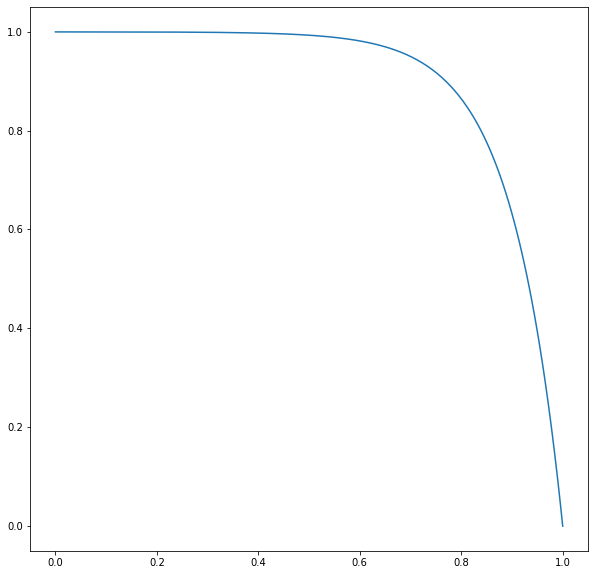

In [10]:
from matplotlib.pyplot import figure
figure(figsize=(10, 10))
plt.plot(x_draw.detach().cpu(), y_draw.detach().cpu())

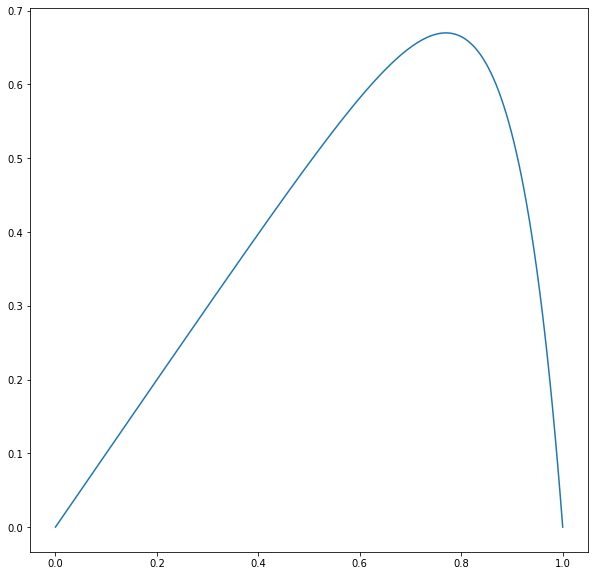

In [11]:
from matplotlib.pyplot import figure
figure(figsize=(10, 10))
plt.plot(x_draw.detach().cpu(), exact_draw.detach().cpu())

In [12]:
exact_sol

tensor([[0.0000e+00],
        [5.0482e-03],
        [1.0096e-02],
        [1.5144e-02],
        [2.0192e-02],
        [2.5239e-02],
        [3.0287e-02],
        [3.5334e-02],
        [4.0381e-02],
        [4.5428e-02],
        [5.0475e-02],
        [5.5522e-02],
        [6.0568e-02],
        [6.5614e-02],
        [7.0660e-02],
        [7.5706e-02],
        [8.0752e-02],
        [8.5797e-02],
        [9.0842e-02],
        [9.5886e-02],
        [1.0093e-01],
        [1.0597e-01],
        [1.1102e-01],
        [1.1606e-01],
        [1.2110e-01],
        [1.2615e-01],
        [1.3119e-01],
        [1.3623e-01],
        [1.4127e-01],
        [1.4631e-01],
        [1.5135e-01],
        [1.5639e-01],
        [1.6143e-01],
        [1.6647e-01],
        [1.7151e-01],
        [1.7655e-01],
        [1.8158e-01],
        [1.8662e-01],
        [1.9166e-01],
        [1.9669e-01],
        [2.0172e-01],
        [2.0676e-01],
        [2.1179e-01],
        [2.1682e-01],
        [2.2185e-01],
        [2